# Language Model
1. DataLoader
2. Model
3. Trainer
4. Generation

이번 실습에서는 RNN기반의 Language Model를 구현해서 텍스트를 직접 생성해보는 실습을 진행해보겠습니다.

- dataset: WikiText2 (https://github.com/pytorch/examples/tree/master/word_language_model/data/wikitext-2)
- model: LSTM




## Import packages

런타임의 유형을 변경해줍니다.

상단 메뉴에서 [런타임]->[런타임유형변경]->[하드웨어가속기]->[GPU]

변경 이후 아래의 cell을 실행 시켰을 때, torch.cuda.is_avialable()이 True가 나와야 합니다.



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
print(torch.__version__)
print(torch.cuda.is_available())

1.12.1+cu113
True


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import tqdm
import os
import random
import time
import datetime

# for reproducibility
random.seed(1234)
np.random.seed(1234)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 1.DataLoader

이전의 실습들에서 사용한것과 마찬가지로, PyTorch style의 dataloader를 먼저 만들어 두겠습니다.

### 1-1.Dataset

저희가 이번 실습에서 사용할 데이터셋은 Wikipedia에 있는 영문 글들을 가져온 WikiTree dataset입니다.
저희가 불러올 데이터는 가장 작은 WikiTree dataset에서 자주 사용되지 않는 단어나 영어가 아닌 단어들은 unknown token ([unk]) 으로 이미 전처리가 되어있습니다.

In [ ]:
import urllib
with urllib.request.urlopen('https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/02-intermediate/language_model/data/train.txt') as f:
    data = f.readlines()

In [ ]:
print('num_sentence:',len(data))
data[100]

num_sentence: 42068


b" plans that give advertisers discounts for maintaining or increasing ad spending have become permanent <unk> at the news <unk> and underscore the fierce competition between newsweek time warner inc. 's time magazine and <unk> b. <unk> 's u.s. news & world report \n"

In [ ]:
data[100].split()

[b'plans',
 b'that',
 b'give',
 b'advertisers',
 b'discounts',
 b'for',
 b'maintaining',
 b'or',
 b'increasing',
 b'ad',
 b'spending',
 b'have',
 b'become',
 b'permanent',
 b'<unk>',
 b'at',
 b'the',
 b'news',
 b'<unk>',
 b'and',
 b'underscore',
 b'the',
 b'fierce',
 b'competition',
 b'between',
 b'newsweek',
 b'time',
 b'warner',
 b'inc.',
 b"'s",
 b'time',
 b'magazine',
 b'and',
 b'<unk>',
 b'b.',
 b'<unk>',
 b"'s",
 b'u.s.',
 b'news',
 b'&',
 b'world',
 b'report']

In [ ]:
# "나는 밥을 먹는다."
kor_data = "나는 밥을 먹는다."
kor_data.split()

['나는', '밥을', '먹는다.']

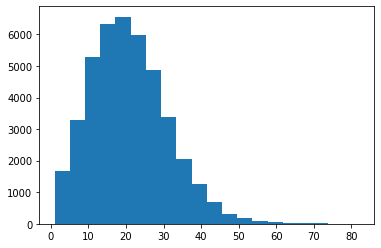

In [ ]:
seq_length_list = []
for line in data:
    seq_length_list.append(len(line.split()))

counts, bins = np.histogram(seq_length_list, bins=20)
plt.hist(bins[:-1], bins, weights=counts)
plt.show()

데이터에 있는 문장 길이들의 histogram을 볼 때 대부분의 data의 문장 길이가 50에 미치지 못하기 때문에 \\
model에 집어넣을 최대 문장 길이를 50으로 세팅해두도록 하겠습니다.

In [ ]:
max_seq_len = 50

### 1-2.Build Dictionary

먼저 text 데이터를 모델에 넣어주기 위해서는 text에 존재하는 단어들을 index로 변환해주어야 합니다.

이를 위해서는 단어를 index로 변환해주는 word2idx dictionary와 다시 index를 단어로 변환해주는 idx2word dictionary를 만들어야 합니다.


In [ ]:
def build_dictionary(data, max_seq_len):
    word2idx = {}
    idx2word = {}
    ## Build Dictionary
    word2idx['<pad>'] = 0
    word2idx['<unk>'] = 1
    idx2word[0] = '<pad>'
    idx2word[1] = '<unk>'
    idx = 2
    for line in data:
        words = line.decode('utf-8').split()
        words = words[:max_seq_len]        
        ### Build Dictionary to convert word to index and index to word
        ### YOUR CODE HERE (~ 5 lines)
        for word in words:
            if word not in word2idx:
                word2idx[word] = idx
                idx2word[idx] = word
                idx += 1

    return word2idx, idx2word

word2idx, idx2word = build_dictionary(data, max_seq_len)

In [ ]:
if len(word2idx) == len(idx2word) == 10000:
    print("Test Passed!")
else:
    raise AssertionError

Test Passed!


### 1-3.Preprocessing

이제 앞서 만든 dictionary를 이용해서 text로된 데이터셋을 index들로 변환시키겠습니다.

In [ ]:
def preprocess(data, word2idx, idx2word, max_seq_len):
    tokens = []
    for line in data:
        words = line.decode('utf-8').split()
        words = words[:max_seq_len]
        ### Convert dataset with tokens
        ### For each line, append <pad> token to match the number of max_seq_len
        ### YOUR CODE HERE (~ 4 lines)
        words += ['<pad>']*(max_seq_len - len(words))
        for word in words:
            token = word2idx[word]
            tokens.append(token)

    return tokens

tokens = preprocess(data, word2idx, idx2word, max_seq_len)

In [ ]:
if len(tokens) == 2103400:
    print("Test Passed!")
else:
    raise AssertionError

Test Passed!


이제 전처리된 Token들을 문장 단위의 배열로 변환시켜 두겠습니다.

In [ ]:
tokens = np.array(tokens).reshape(-1, max_seq_len)
print(tokens.shape)
tokens[100]

(42068, 50)


array([745,  93, 746, 739, 747, 181, 748, 467, 749, 740, 750, 154, 751,
       752,   1, 160,  32, 753,   1,  48, 754,  32, 755, 756, 757, 728,
       555, 758,  99, 119, 555, 733,  48,   1, 759,   1, 119, 237, 753,
       230, 760, 347,   0,   0,   0,   0,   0,   0,   0,   0])

### 1-4.DataLoader

이제 전처리된 dataset을 활용하여 PyTorch style의 dataset과 dataloader를 만들도록 하겠습니다.

Token형태의 데이터를 PyTorch 스타일의 dataset으로 만들 때 주의할 점은, 추후 embedding matrix에서 indexing을 해주기 위해서 각 token이 LongTensor 형태로 정의되어야 한다는 점입니다.

In [ ]:
class LMDataset(torch.utils.data.Dataset):
    def __init__(self, tokens):
        super(LMDataset, self).__init__()
        self.PAD = 0
        self.UNK = 1
        self.tokens = tokens
        self._getitem(2)

    def _getitem(self, index):
        X = self.tokens[index]
        y = np.concatenate((X[1:], [self.PAD]))

        X = torch.from_numpy(X).unsqueeze(0).long()
        y = torch.from_numpy(y).unsqueeze(0).long()

        return X, y

    def __getitem__(self, index):
        X = self.tokens[index]
        y = np.concatenate((X[1:], [self.PAD]))

        X = torch.from_numpy(X).long()
        y = torch.from_numpy(y).long()

        return X, y

    def __len__(self):
        return len(self.tokens)

In [ ]:
batch_size = 64
dataset = LMDataset(tokens)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

print(len(dataset))
print(len(dataloader))

42068
658


# 2.Model

이번 section에서는 Language Modeling을 위한 Recurrent Model을 직접 만들어보도록 하겠습니다.

Standard한 Recurrent Neural Network (RNN) model은 vanishing gradient 문제에 취약하기 때문에, 이번 실습에서는 변형된 RNN구조인 LSTM model을 활용하도록 하겠습니다.


### 2-1.LSTM

LSTM model의 전체적인 구조와 각 gate의 수식은 아래와 같습니다.

![](https://drive.google.com/uc?export=view&id=1n93tpNW55Xl4GxZNcJcbUVRhuNCGH38h)

![](https://drive.google.com/uc?export=view&id=1nH9U5iD9cO6OVVTbrx-LjypRvcWzbOCU)

LSTM의 자세한 동작방식이 궁금하신 분은 아래의 블로그를 참조해주세요.

https://colah.github.io/posts/2015-08-Understanding-LSTMs/

In [ ]:
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMCell, self).__init__()
        # input-gate
        self.Wi = nn.Linear(input_size + hidden_size, hidden_size)
        # forget-gate
        self.Wf = nn.Linear(input_size + hidden_size, hidden_size)
        # gate-gate
        self.Wg = nn.Linear(input_size + hidden_size, hidden_size)
        # output-gate
        self.Wo = nn.Linear(input_size + hidden_size, hidden_size)

        # non-linearity
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def forward(self, x, h_0, c_0):
        """
        Inputs
            input (x): [batch_size, input_size]
            hidden_state (h_0): [batch_size, hidden_size]
            cell_state (c_0): [batch_size, hidden_size]
        Outputs
            next_hidden_state (h_1): [batch_size, hidden_size]
            next_cell_state (c_1): [batch_size, hidden_size]    
        """
        h_1, c_1 = None, None
        input = torch.cat((x, h_0), 1)
        # Implement LSTM cell as noted above
        ### YOUR CODE HERE (~ 6 lines)
        i = self.sigmoid(self.Wi(input))
        f = self.sigmoid(self.Wf(input))
        g = self.tanh(self.Wg(input))
        o = self.sigmoid(self.Wo(input))
        c_1 = f * c_0 + i * g
        h_1 = o * self.tanh(c_1)

        return h_1, c_1

In [ ]:
def test_lstm():
    batch_size = 2
    input_size = 5
    hidden_size = 3

    #torch.manual_seed(1234)
    lstm = LSTMCell(input_size ,hidden_size)
    def init_weights(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.constant_(m.weight, 0.1)
            m.bias.data.fill_(0.01)
    lstm.apply(init_weights)

    x = torch.ones(batch_size, input_size)
    hx = torch.zeros(batch_size, hidden_size)
    cx = torch.zeros(batch_size, hidden_size)

    hx, cx = lstm(x, hx, cx)
    assert hx.detach().allclose(torch.tensor([[0.1784, 0.1784, 0.1784], 
                                              [0.1784, 0.1784, 0.1784]]), atol=2e-1), \
            f"Output of the hidden state does not match."
    assert cx.detach().allclose(torch.tensor([[0.2936, 0.2936, 0.2936], 
                                              [0.2936, 0.2936, 0.2936]]), atol=2e-1), \
            f"Output of the cell state does not match."

    print("==LSTM cell test passed!==")

test_lstm()

==LSTM cell test passed!==


## 2-2.Language Model

이제, 위에서 정의한 LSTM Cell을 활용해서 아래와 같은 Langauge Model을 만들어보도록 하겠습니다.


![](https://drive.google.com/uc?export=view&id=1nMAbL-g31nERM44dgohA3k9Vj_92hIh-)

In [ ]:
class LanguageModel(nn.Module):
    def __init__(self, input_size=64, hidden_size=64, vocab_size=10000):
        super(LanguageModel, self).__init__()
        
        self.input_layer = nn.Embedding(vocab_size, input_size)
        self.hidden_layer = LSTMCell(input_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, vocab_size)


    def forward(self, x, hx, cx, predict=False):
        """
        Inputs
            input (x): [batch_size]
            hidden_state (h_0): [batch_size, hidden_size]
            cell_state (c_0): [batch_size, hidden_size]
            predict: whether to predict and sample the next word
        Outputs
            output (ox): [batch_size, hidden_size]
            next_hidden_state (h_1): [batch_size, hidden_size]
            next_cell_state (c_1): [batch_size, hidden_size]    
        """
        x = self.input_layer(x)
        hx, cx = self.hidden_layer(x, hx, cx)
        ox = self.output_layer(hx)

        if predict == True:
            probs = F.softmax(ox, dim=1)
            # torch distribution allows sampling operation
            # see https://pytorch.org/docs/stable/distributions.html
            dist = torch.distributions.Categorical(probs)
            ox = dist.sample()

        return ox, hx, cx  

# 3.Trainer

자 이제 위에서 구현한 dataloader와 langauge model을 활용해서 모델의 학습을 진행해보도록 하겠습니다.


In [ ]:
class Trainer():
    def __init__(self, 
                 word2idx, 
                 idx2word,
                 dataloader, 
                 model, 
                 criterion,
                 optimizer, 
                 device):
        """
        dataloader: dataloader
        model: langauge model
        criterion: loss function to evaluate the model (e.g., BCE Loss)
        optimizer: optimizer for model
        """
        self.word2idx = word2idx
        self.idx2word = idx2word
        self.dataloader = dataloader
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        
    def train(self, epochs = 1):
        self.model.to(self.device)
        start_time = time.time()
        for epoch in range(epochs):
            losses = []
            for iter, (x_batch, y_batch) in tqdm.tqdm(enumerate(self.dataloader)):
                self.model.train()
                
                batch_size, max_seq_len = x_batch.shape
                x_batch = x_batch.to(self.device)
                y_batch = y_batch.to(self.device)

                # initial hidden-states
                hx = torch.zeros(batch_size, hidden_size).to(self.device)
                cx = torch.zeros(batch_size, hidden_size).to(self.device)

                # Implement LSTM operation
                ox_batch = []
                # Get output logits for each time sequence and append to the list, ox_batch
                # YOUR CODE HERE (~ 4 lines)
                for s_idx in range(max_seq_len):
                    x = x_batch[:, s_idx]
                    ox, hx, cx = self.model(x, hx, cx)
                    ox_batch.append(ox)
                # outputs are ordered by the time sequence
                ox_batch = torch.cat(ox_batch).reshape(max_seq_len, batch_size, -1)
                ox_batch = ox_batch.permute(1,0,2).reshape(batch_size*max_seq_len, -1)
                y_batch = y_batch.reshape(-1)

                self.model.zero_grad()
                loss = self.criterion(ox_batch, y_batch)
                loss.backward()
                self.optimizer.step()
                losses.append(loss.item())

            end_time = time.time() - start_time
            end_time = str(datetime.timedelta(seconds=end_time))[:-7]
            print('Time [%s], Epoch [%d/%d], loss: %.4f'
                  % (end_time, epoch+1, epochs, np.mean(losses)))
            if epoch % 5 == 0:
                generated_sentences = self.test()
                print('[Generated Sentences]')
                for sentence in generated_sentences:
                    print(sentence)
            
    def test(self):
        # Test model to genereate the sentences
        self.model.eval()
        num_sentence = 5
        max_seq_len = 50

        # initial hidden-states
        outs = []
        x = torch.randint(0, 10000, (num_sentence,)).to(self.device)
        hx = torch.zeros(num_sentence, hidden_size).to(self.device)
        cx = torch.zeros(num_sentence, hidden_size).to(self.device)

        outs.append(x)
        with torch.no_grad():
            for s_idx in range(max_seq_len-1):
                x, hx, cx = self.model(x, hx, cx, predict=True)
                outs.append(x)
        outs = torch.cat(outs).reshape(max_seq_len, num_sentence)
        outs = outs.permute(1, 0)
        outs = outs.detach().cpu().numpy()

        sentences = []
        for out in outs:
            sentence = []
            for token_idx in out:
                word = self.idx2word[token_idx]
                sentence.append(word)
            sentences.append(sentence)
       
        return sentences

In [ ]:
lr = 1e-2
input_size = 128
hidden_size = 128
batch_size = 256

dataset = LMDataset(tokens)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
model = LanguageModel(input_size=input_size, hidden_size=hidden_size)
# NOTE: you should use ignore_index to ignore the loss from predicting the <PAD> token
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=lr)
device = torch.device('cuda')

trainer = Trainer(word2idx = word2idx,
                  idx2word = idx2word,
                  dataloader=dataloader, 
                  model = model,
                  criterion=criterion,
                  optimizer = optimizer,
                  device=device)

trainer.train(epochs=50)

165it [00:23,  7.13it/s]


Time [0:00:23], Epoch [1/50], loss: 6.0914
[Generated Sentences]
['bebear', 'bank', 'services', 'range', 'minutes', 'of', 'native', 'equitable', 'to', 'labor', 'and', '<unk>', '<unk>', 'in', 'the', 'matter', 'of', 'the', 'recent', 'ad', 'expects', 'later', 'the', 'sidelines', 'in', 'the', 'weekend', 'N', 'junk', 'market', 'president', 'of', 'the', 'city', 'committee', 'ought', 'to', 'strange', 'if', 'anything', 'agreeing', 'involved', 'in', 'transfer', 'and', 'the', 'entire', 'u.s.', 'fund', 'facilities']
['temperatures', 'tap', 'steven', 'step', 'are', 'officials', 'to', 'them', 'after', 'that', '<unk>', '<unk>', 'a', 'duty', 'could', 'be', 'already', 'caused', 'available', 'in', 'sluggish', '<unk>', 'practices', 'ca', "n't", 'act', 'that', 'they', 'do', 'the', 'baby', 'is', 'made', 'to', 'bans', 'and', 'their', 'governments', 'like', 'investors', 'say', 'we', 'can', 'got', 'their', 'legislative', 'idea', 'ruling', 'the', 'rural']
['admission', 'together', 'yes', 'between', 'the', '<u

165it [00:15, 10.33it/s]


Time [0:00:39], Epoch [2/50], loss: 5.2233


165it [00:15, 10.36it/s]


Time [0:00:55], Epoch [3/50], loss: 4.9047


165it [00:15, 10.37it/s]


Time [0:01:11], Epoch [4/50], loss: 4.6957


165it [00:16,  9.96it/s]


Time [0:01:27], Epoch [5/50], loss: 4.5364


165it [00:16, 10.20it/s]


Time [0:01:43], Epoch [6/50], loss: 4.4092
[Generated Sentences]
['distributed', 'at', 'returning', 'drugs', '<unk>', 'some', 'walls', 'and', 'work', 'after', 'the', 'case', 'will', 'act', 'we', "'ve", 'been', 'created', 'in', 'the', 'cost', 'of', 'being', '<unk>', 'to', 'the', 'power', 'round', 'of', 'substantially', 'their', '<unk>', 'conflicts', 'so', 'many', 'lawmakers', 'says', 'sir', 'james', 'a.', 'johnson', 'jr.', 'led', 'by', 'farmers', 'components', 'inc.', 'on', 'its', 'addition']
['shouting', 'wind', 'up', 'always', 'remain', 'wary', 'of', 'the', 'federal', 'government', "'s", 'request', 'for', 'the', 'high', 'tax', 'show', 'mr.', 'straszheim', "'s", 'school', 'who', 'resigned', 'and', 'the', 'policy', 'had', 'had', 'made', 'it', 'to', 'do', 'so', 'soon', 'to', 'be', 'the', 'game', 'cold', 'fusion', 'experiments', 'to', 'provide', 'the', 'horrible', 'certain', 'cancer', 'opportunity', 'to', 'the']
['death', 'encouraging', 'customers', 'suspension', 'to', 'add', 'the', 'cros

165it [00:16,  9.73it/s]


Time [0:02:00], Epoch [7/50], loss: 4.3017


165it [00:16, 10.24it/s]


Time [0:02:16], Epoch [8/50], loss: 4.2109


165it [00:16, 10.26it/s]


Time [0:02:33], Epoch [9/50], loss: 4.1303


165it [00:16, 10.25it/s]


Time [0:02:49], Epoch [10/50], loss: 4.0613


165it [00:16, 10.25it/s]


Time [0:03:05], Epoch [11/50], loss: 3.9982
[Generated Sentences]
['mount', 'advancing', 'two', 'years', 'ago', 'the', 'increased', 'problem', 'its', 'lost', 'contact', 'with', 'on', '<unk>', 'small', 'so-called', 'bells', 'intimate', '<unk>', 'ca', 'to', 'make', '<unk>', 'more', 'information', 'around', 'polaroid', 'and', 'information', 'to', 'prosecutors', 'not', 'only', 'the', 'khmer', 'rouge', 'child', 'involved', '<unk>', 'milk', '<unk>', 'and', 'talent', 'of', 'giving', 'research', '<unk>', 'to', 'japan', 'says']
['karen', 'mitchell', 'analyst', 'for', 'painewebber', 'group', 'inc.', 'in', 'boston', 'corp.', 'the', 'american', 'defense', '&', 'north', 'american', 'firms', 'the', 'bank', 'switzerland', '&', 'finance', 'group', 'by', 'post', 'that', 'means', 'credits', 'appear', 'commission', 'over', 'part', 'of', 'caci', 'annual', 'sales', '$', 'N', 'million', 'otc', 'on', 'its', 'light', 'price', 'discrepancies', 'between', 'cineplex', "'s", 'california', 'plant']
['levine', 'hav

165it [00:16, 10.23it/s]


Time [0:03:21], Epoch [12/50], loss: 3.9407


165it [00:16, 10.09it/s]


Time [0:03:37], Epoch [13/50], loss: 3.8910


165it [00:16, 10.26it/s]


Time [0:03:53], Epoch [14/50], loss: 3.8451


165it [00:16, 10.23it/s]


Time [0:04:10], Epoch [15/50], loss: 3.8019


165it [00:16, 10.25it/s]


Time [0:04:26], Epoch [16/50], loss: 3.7647
[Generated Sentences]
['jr', 'finnish', '<unk>', '<unk>', 'former', 'writer', 'who', 'took', 'a', 'japanese', 'journalist', 'that', 'the', 'show', 'brooks', 'brothers', 'said', 'the', 'company', 'has', 'been', 'both', 'later', 'in', 'any', 'legal', 'commitment', 'from', 'lenders', 'to', 'make', 'sure', 'larger', 'and', 'computer', 'chips', 'on', '<unk>', 'like', 'general', 'electric', 'zones', 'and', 'a', 'luxury', 'infiniti', 'or', '<unk>', 'efforts', 'on']
['vincent', '<unk>', '<unk>', 'whose', 'prototype', '<unk>', 'in', 'australia', 'to', 'the', 'emergency', 'producers', 'add', 'fiat', 'research', 'and', 'joseph', 'm.', 'trotter', 'iii', 'and', 'william', '<unk>', 'd.', '<unk>', 'a', 'small', 'investor', 'who', 'reached', 'an', 'investment', 'banking', 'division', 'with', 'individual', 'gov.', 'schools', 'scattered', 'and', 'the', 'two', 'jacobson', 'who', 'spoke', 'on', 'the', 'long-term', 'ad', 'plan']
['caution', 'made', 'two', 'work',

165it [00:16, 10.28it/s]


Time [0:04:42], Epoch [17/50], loss: 3.7286


165it [00:16, 10.20it/s]


Time [0:04:58], Epoch [18/50], loss: 3.6966


165it [00:16, 10.27it/s]


Time [0:05:14], Epoch [19/50], loss: 3.6645


165it [00:16, 10.24it/s]


Time [0:05:30], Epoch [20/50], loss: 3.6383


165it [00:16, 10.20it/s]


Time [0:05:46], Epoch [21/50], loss: 3.6131
[Generated Sentences]
['clearly', 'the', 'powers', 'takes', 'effect', 'even', '<unk>', 'that', 'mr.', 'smith', 'should', 'have', 'turned', 'up', 'to', 'it', 'several', 'trends', 'in', 'the', '<unk>', 'nagging', '<unk>', 'and', 'function', 'need', 'considering', '<unk>', 'to', 'use', 'a', 'debate', 'in', 'the', 'capability', 'to', 'stop', 'and', 'execute', 'departments', 'in', 'the', 'city', 'for', 'red', 'square', 'plans', 'to', 'write', 'a']
['begun', 'military', 'nicholas', 'remain', '<unk>', 'by', 'the', 'new', 'york', 'company', 'that', 'excluding', 'the', 'dollar', 'against', 'the', 'warsaw', 'pact', 'with', 'proposed', 's&l', 'of', '<unk>', 'leading', 'electrical', 'engineering', 'and', 'marketing', 'operations', 'at', 'washington', 'jan.', 'N', 'succeeding', 'john', '<unk>', 'an', 'analyst', 'with', 'eli', 'lilly', '&', 'co.', 'in', 'a', 'house', 'speech', 'made', 'by', 'ogden']
['trained', '<unk>', 'and', '<unk>', 'forms', 'the', 'cha

165it [00:16, 10.28it/s]


Time [0:06:02], Epoch [22/50], loss: 3.5907


165it [00:16, 10.25it/s]


Time [0:06:19], Epoch [23/50], loss: 3.5662


165it [00:16, 10.24it/s]


Time [0:06:35], Epoch [24/50], loss: 3.5468


165it [00:16, 10.06it/s]


Time [0:06:51], Epoch [25/50], loss: 3.5277


165it [00:16, 10.25it/s]


Time [0:07:07], Epoch [26/50], loss: 3.5084
[Generated Sentences]
['semiconductors', 'mateo', 'happens', 'relief', 'cooperation', 'the', '<unk>', 'brother', '<unk>', 'in', 'his', '<unk>', '<unk>', 'a', 'contemporary', '<unk>', '<unk>', '<unk>', '<unk>', 'and', 'that', '<unk>', 'does', "n't", 'increase', 'the', 'sec', 'does', "n't", 'work', 'with', 'congressional', 'criticism', 'he', 'has', '<unk>', 'she', 'adds', 'h&r', 'block', 'grant', 'recipients', '<unk>', 'it', 'in', 'the', 'process', 'of', 'winning', 'a']
['jerome', 'triple', 'your', '<unk>', 'in', 'any', 'new', 'somehow', 'bought', 'from', 'the', 'provision', 'in', 'the', 'day', "'s", 'N', 'hours', 'a', 'year', 'if', 'not', 'mean', 'they', 'had', 'a', 'century', 'at', 'it', 'to', 'get', 'back', 'to', 'square', 'mr.', 'guber', 'and', 'his', 'audience', "'s", 'aggressive', 'in', 'the', '<unk>', 'the', 'number', 'of', 'blacks', 'or', 'part']
['concern', 'that', 'makes', 'supermarket', '<unk>', 'versions', 'of', '<unk>', 'advertisin

165it [00:16, 10.28it/s]


Time [0:07:23], Epoch [27/50], loss: 3.4913


165it [00:16, 10.25it/s]


Time [0:07:39], Epoch [28/50], loss: 3.4758


165it [00:16, 10.23it/s]


Time [0:07:56], Epoch [29/50], loss: 3.4597


165it [00:16, 10.28it/s]


Time [0:08:12], Epoch [30/50], loss: 3.4463


165it [00:16, 10.30it/s]


Time [0:08:28], Epoch [31/50], loss: 3.4343
[Generated Sentences]
['bradstreet', "'s", 'junk', 'bond', 'buyer', 'said', 'it', 'has', 'only', 'N', 'million', 'common', 'shares', 'of', 'issues', 'for', 'producing', 'funds', 'available', 'for', 'next', 'year', "'s", '$', 'N', 'million', 'mortgage', 'securities', 'but', 'depressed', 'gold', 'reserves', 'improve', 'generally', 'contracting', 'under', 'the', 'company', 'said', 'third-quarter', 'net', 'income', 'rose', 'N', 'N', 'to', '$', 'N', 'million', 'or']
['x', 'there', 'are', 'angry', 'ibm', 'for', 'an', 'accident', 'and', 'the', 'idea', 'that', 'they', '<unk>', 'all', 'everything', 'can', 'be', 'printed', 'in', 'leipzig', 'from', 'N', 'he', 'said', 'in', 'an', 'interview', 'oct.', 'N', 'of', 'investors', 'once', 'the', 'issue', 'for', 'foreign', 'magazines', 'oversight', 'and', 'may', 'determine', 'how', 'supreme', 'electoral', 'aid', 'is', 'that', 'it', 'is']
['cooking', 'class-action', 'letter', 'of', 'a', 'distinguished', '<unk>', 

165it [00:16, 10.24it/s]


Time [0:08:44], Epoch [32/50], loss: 3.4218


165it [00:15, 10.32it/s]


Time [0:09:00], Epoch [33/50], loss: 3.4105


165it [00:16, 10.29it/s]


Time [0:09:16], Epoch [34/50], loss: 3.4001


165it [00:16, 10.22it/s]


Time [0:09:32], Epoch [35/50], loss: 3.3903


165it [00:16, 10.30it/s]


Time [0:09:48], Epoch [36/50], loss: 3.3806
[Generated Sentences]
['battered', 'cure', 'no', 'emergency', 'relief', 'for', 'governors', 'over', 'the', 'past', 'week', 'or', 'too', 'many', 'of', 'these', 'actions', 'and', 'at', 'noon', 'promised', 'to', 'notify', 'federal', 'reserve', 'to', 'promote', 'initiatives', 'show', 'what', 'of', 'both', 'houses', 'were', 'the', 'bid', 'to', 'insurance', 'collect', 'through', 'coffee', 'cases', 'from', 'court', 'competing', '<unk>', 'and', 'public', 'utilities', 'in']
['commitments', 'outperformed', 'international', 'business', 'for', 'merchant', 'banking', "'s", 'says', 'john', 'lang', 'reservations', 'the', 'u.s.', 'government', 'voted', 'instead', 'of', 'more', '<unk>', 'before', 'they', "'d", 'let', 'a', 'satisfaction', 'to', 'the', '<unk>', 'group', 'of', 'acquiring', 'the', 'western', 'desire', 'of', 'the', 'nation', "'s", 'largest', 'securities', 'units', 'just', 'so', 'far', 'is', 'this', 'to', 'say', 'they']
['va', 'urges', 'greater', '

165it [00:16, 10.09it/s]


Time [0:10:05], Epoch [37/50], loss: 3.3746


165it [00:16, 10.26it/s]


Time [0:10:21], Epoch [38/50], loss: 3.3645


165it [00:16, 10.28it/s]


Time [0:10:37], Epoch [39/50], loss: 3.3569


165it [00:16, 10.30it/s]


Time [0:10:53], Epoch [40/50], loss: 3.3485


165it [00:16, 10.23it/s]


Time [0:11:09], Epoch [41/50], loss: 3.3393
[Generated Sentences]
['whether', 'it', 'is', 'a', '<unk>', 'that', 'have', 'been', 'sold', 'for', 'about', '$', 'N', 'of', 'an', 'equity', 'fund', 'products', 'on', 'the', 'common', 'stock', 'fund', 'this', 'year', 'said', 'its', 'plan', 'to', 'bolster', 'net', 'income', 'of', '$', 'N', 'million', 'or', 'N', 'cents', 'a', 'share', 'from', '$', 'N', 'million', 'or', 'N', 'cents', 'a', 'share']
['emissions', 'trimmed', 'trim', 'closer', 'access', 'to', 'managers', 'when', 'markets', 'participation', 'in', 'singapore', 'which', 'provides', 'sluggish', 'for', 'the', 'contract', 'directly', 'to', 'provide', 'the', 'problems', 'of', 'technology', 'before', 'the', 'local', 'subway', 'line', 'to', '<unk>', 'near', '<unk>', '<unk>', 'with', 'an', 'import', 'and', 'local', 'views', 'on', 'the', 'corporate', '<unk>', 'and', '<unk>', 'they', "'d", 'regulate']
['monitoring', 'al', '<unk>', 'for', 'maryland', 'gives', 'the', '<unk>', 'method', 'of', 'the'

165it [00:16, 10.25it/s]


Time [0:11:25], Epoch [42/50], loss: 3.3346


165it [00:16, 10.26it/s]


Time [0:11:41], Epoch [43/50], loss: 3.3277


165it [00:16, 10.23it/s]


Time [0:11:57], Epoch [44/50], loss: 3.3243


165it [00:16, 10.30it/s]


Time [0:12:13], Epoch [45/50], loss: 3.3196


165it [00:16, 10.30it/s]


Time [0:12:29], Epoch [46/50], loss: 3.3118
[Generated Sentences]
['good', 'luck', 'where', 'she', 'seems', 'to', 'me', 'how', 'necessary', 'to', 'write', 'these', 'cases', 'freeze', 'you', 'ca', "n't", 'anything', 'happen', 'in', 'the', 'market', 'on', 'oct.', 'N', 'through', 'N', 'commissioned', 'salesmen', 'would', 'pose', 'a', 'regular', '<unk>', 'for', 'surgery', '<unk>', 'by', 'the', 'global', 'market', 'and', 'weeks', 'themselves', 'as', 'soon', 'as', 'once', 'as', 'full']
['vermont-slauson', 'patent', 'enemies', 'are', 'bracing', 'for', 'a', 'severe', 'fax', 'product', 'with', 'mr.', 'lawson', "'s", 'volatility', 'interested', 'in', 'antitrust', 'suit', 'to', 'supply', 'such', 'proceedings', 'by', 'adopting', 'a', 'requiring', 'exchange', 'inquiry', 'in', 'ports', 'around', 'the', 'best', 'circumstances', 'from', 'campeau', 'corp.', 'in', 'a', 'transaction', 'that', 'it', 'is', 'discussing', 'an', 'extension', 'of', 'suggestion', 'from']
['duke', 'exist', 'brokers', 'was', 'des

165it [00:16, 10.26it/s]


Time [0:12:45], Epoch [47/50], loss: 3.3057


165it [00:16, 10.30it/s]


Time [0:13:01], Epoch [48/50], loss: 3.3019


165it [00:16, 10.11it/s]


Time [0:13:18], Epoch [49/50], loss: 3.2964


165it [00:15, 10.32it/s]

Time [0:13:34], Epoch [50/50], loss: 3.2953


# References

1. https://github.com/pytorch/examples/tree/master/word_language_model
2. https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/02-intermediate/language_model